In [2]:
import sys

sys.path.insert(1, '../')

#from feature_extraction.variational_autoencoder.vae_feature_extractor import Vae_Feature_Extractor
from feature_extraction.variational_autoencoder.vae_feature_extractor_torch import Vae_Feature_Extractor
from feature_prediction.long_short_term_memory.lstm_prediction_model import Lstm_prediction_model
from feature_prediction.deep_transformer.deep_transformer import Transformer_prediction_model
from arbitrage_free_ivs.nsa_ivs_dnn import NSA_IVS_DNN
#from arbitrage_free_ivs.nsa_ivs_dnn_torch import NSA_IVS_DNN
from arbitrage_free_ivs.plot_ivs import IV_Plotting_Helper
from feature_prediction.plot.plot_helper_functions import plot_features_with_prediction

import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
test_id = 3
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

"""
test_id 3: aplha, beta, rho, S0, V0 = [0.6, 0.7, -0.6, 1., 0.1] + eps_i \sim N(0,0.005) 
and alpha_i - 0.1 * cos(i/200) + 0.05 * cos(i/400), beta_i + 0.1 * cos(i/400)
"""

iv_data = np.genfromtxt(f"../data/test{test_id}_data_sabr_train.csv", delimiter=',').reshape((10000, 12, 16, 1)).astype('float32')

In [4]:
call_data = np.genfromtxt(f"../data/test{test_id}_call_data_sabr_train.csv", delimiter=',').reshape((10000, 12, 16)).astype('float32')

# Feature Extraction: VAE

In [5]:
feature_dim = 4

feature_extractor = Vae_Feature_Extractor(
    file_name = f"../data/test{test_id}_data_sabr_train.csv", 
    shape = (10000, 12, 16, 1),
    params = {
        "feature_dim": feature_dim,
        "batch_size": 32,
        "beta": 0.02,
    }
)

In [6]:
# train vae
history = feature_extractor.train(250)
# save vae
feature_extractor.save_model(f"vae_{test_id}_")

Epoch: 0 Reconstruction Loss: 25.285225786590576 KL Loss: 1879.4587029018403 Total Loss: 1904.7438949111938
Epoch: 1 Reconstruction Loss: 4.235807691574097 KL Loss: 0.27609943218994143 Total Loss: 4.511907123184204
Epoch: 2 Reconstruction Loss: 3.0547392921447756 KL Loss: 0.2651275678100586 Total Loss: 3.319866849899292
Epoch: 3 Reconstruction Loss: 2.7857410652160643 KL Loss: 0.2601869465332031 Total Loss: 3.045928003692627
Epoch: 4 Reconstruction Loss: 2.3398710147857664 KL Loss: 0.2562924905090332 Total Loss: 2.5961634979248047
Epoch: 5 Reconstruction Loss: 2.3053905700683592 KL Loss: 0.25290814459228517 Total Loss: 2.558298709487915
Epoch: 6 Reconstruction Loss: 2.3021425579071044 KL Loss: 0.24892996459960937 Total Loss: 2.5510725147247313
Epoch: 7 Reconstruction Loss: 2.306154976272583 KL Loss: 0.24326245629882814 Total Loss: 2.549417428970337
Epoch: 8 Reconstruction Loss: 2.3380216377258303 KL Loss: 0.23984300360107422 Total Loss: 2.57786463394165
Epoch: 9 Reconstruction Loss: 2.

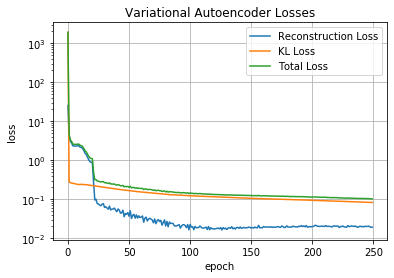

In [7]:
from matplotlib import pyplot as plt

plt.plot(history)
plt.title('Variational Autoencoder Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Reconstruction Loss','KL Loss', 'Total Loss'], loc='upper right')
plt.grid()
plt.yscale("log")
#plt.ylim(1e-7,1e5)

#plt.show()
plt.savefig("vae_losses.pdf")

In [8]:
# load vae
feature_extractor.load_model(f"vae_{test_id}_")

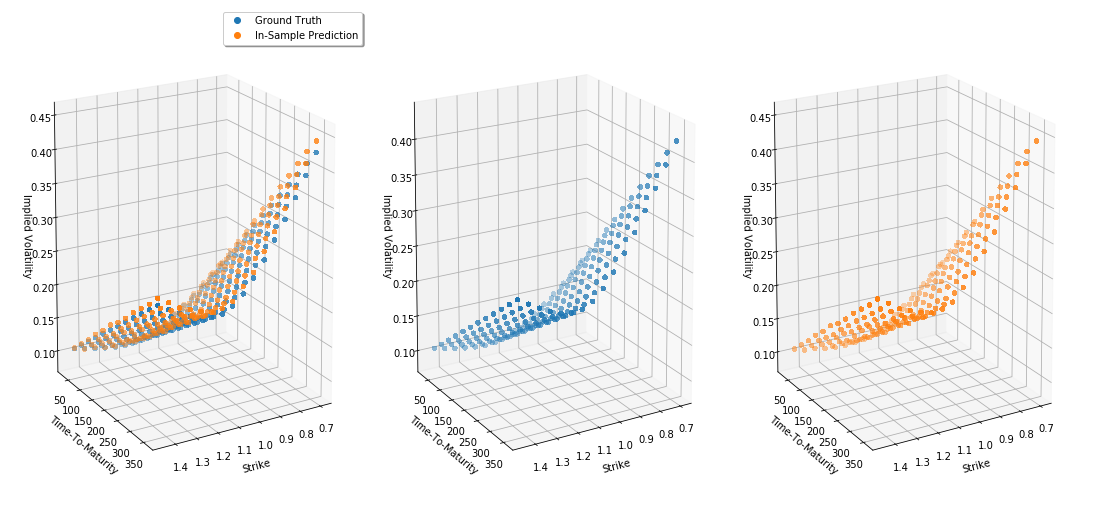

In [9]:
ind = 5069

z = feature_extractor.autoencoder.encoder(torch.from_numpy(iv_data))
rec = feature_extractor.autoencoder.decoder(z).detach().numpy()

strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

plot_data = {
    "iv_grid_1": iv_data[ind:ind+1],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": rec[ind:ind+1],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "legend": ["Ground Truth","In-Sample Prediction"]
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 0, view_angle=(15, 60))

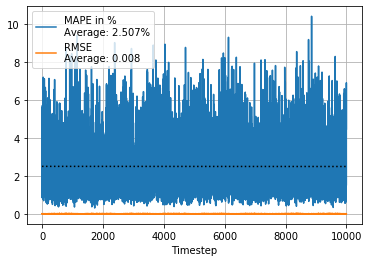

In [10]:
true_ivs = iv_data[:,:,:,0]
predicted_ivs = rec[:,:,:,0]

mape = np.mean(np.abs(true_ivs-predicted_ivs)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_ivs,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)

mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")
plt.grid()

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")
#plt.title("Train IV grids to VAE Encoder-Decoder IV Grids")
plt.savefig("MAPE_VAE.pdf")

In [11]:
# save feature space data
data = np.genfromtxt(f"../data/test{test_id}_data_sabr_train.csv", delimiter=',').reshape((10000, 12, 16, 1)).astype('float32')
print("data shape:",data.shape)
feature_data = feature_extractor.produce_features(data)
print("feature data shape:",feature_data.shape)
feature_extractor.save_produced_features(f"latent_space_data/features_{test_id}_train")

data shape: (10000, 12, 16, 1)
feature data shape: (10000, 4)


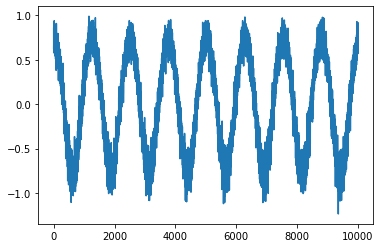

In [21]:
plt.plot(feature_data[:,3])

# Feature Prediction: Train Transformer

In [6]:
# load data and create data set with features
feature_data = np.genfromtxt(f"latent_space_data/features_{test_id}_train_vae_model", delimiter=',').astype('float32')
print(feature_data.shape)

look_back = 100
num_data_points = feature_data.shape[0]
num_train_data_points = int(0.7*num_data_points)

transformer_model = Transformer_prediction_model(
    feature_data, 
    params={"look_back": look_back, "forecast_window": 200},
    decoder=feature_extractor.autoencoder.decoder,
    call_prices=call_data,
    strikes=strikes,
    ttms=ttms
)

(10000, 4)
Data shape with extra features:  (10000, 8)


In [36]:
# train the model
path = f"./models/deep_transformer/res{test_id}/"
best_model = transformer_model.transformer_no_dynamic_arbitrage(
    epochs=5, 
    path_to_save_model=path, 
    path_to_save_loss=path, 
    device="cpu",
    beta_feature_mse=0.0
)
print(best_model)

Epoch: 0 , Call Grids MSE Loss: 0.014228190649673815
Epoch: 1 , Call Grids MSE Loss: 0.012862552968093431
Epoch: 2 , Call Grids MSE Loss: 0.012582505859075263
Epoch: 3 , Call Grids MSE Loss: 0.012350584437105157
Epoch: 4 , Call Grids MSE Loss: 0.012101671048680956
Epoch: 5 , Call Grids MSE Loss: 0.011832322411273731
best_train_NDA_5.pth


In [37]:
path = f"./models/deep_transformer/res{test_id}/"
best_model = "best_train_NDA_5.pth"
#best_model = "best_train_1.pth"

In [38]:
# Get in sample errors
in_sample_errors = transformer_model.in_sample_errors(path, best_model) 
print(in_sample_errors.shape)

(10000, 4)


## Make Predictions for new data

In [39]:
# Create feature data for new data
data_test = np.genfromtxt(f"../data/test{test_id}_data_sabr_test.csv", delimiter=',').reshape((600, 12, 16, 1)).astype('float32')
print("test data shape:",data_test.shape)
feature_data_test = feature_extractor.produce_features(data_test)
print("feature data test shape:",feature_data_test.shape)


test data shape: (600, 12, 16, 1)
feature data test shape: (600, 4)


### Inference on test data without training 

In [40]:
prediction_features = transformer_model.inference_with_new_data(feature_data_test, path, best_model)
print(prediction_features.shape)

Data shape with extra features:  (600, 8)
(200, 4)


(200, 4)


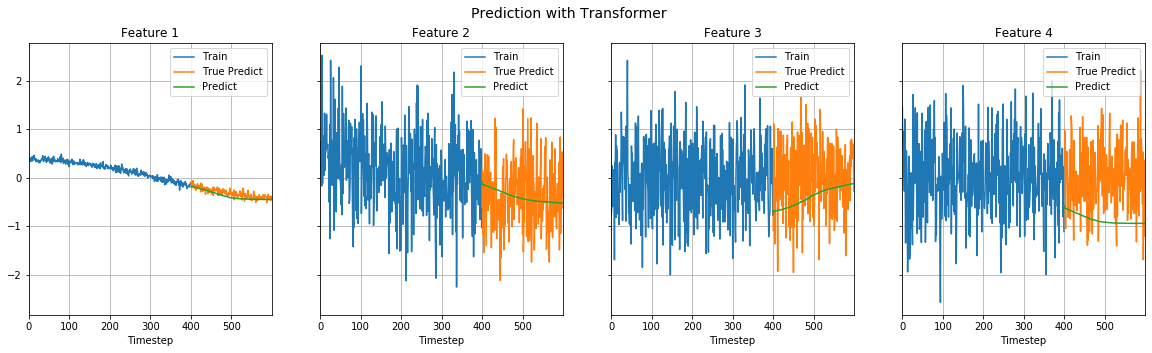

In [84]:
num_train_data_points = 600 - 200

true_ = feature_data_test[num_train_data_points:]

boot_strap_errors = in_sample_errors[np.random.randint(low=0, high=in_sample_errors.shape[0], size=true_.shape[0]),:]
print(boot_strap_errors.shape)
pred_vec = prediction_features#+boot_strap_errors
#pred_vec = prediction_features+in_sample_errors[400:600]


fig = plot_features_with_prediction(
    data=feature_data_test[:num_train_data_points],
    prediction=pred_vec,
    true_predictions=true_,
    use_true_predictions=True,
    save_path_and_name=f"prediction_with_transformer_test{test_id}.pdf",
    params={
        "fig_title":"Prediction with Transformer",
        "share_y": True
    }
)

In [85]:
predicted_iv_grids = feature_extractor.create_iv_grids_from_features(pred_vec)
print(predicted_iv_grids.shape)

(200, 12, 16, 1)


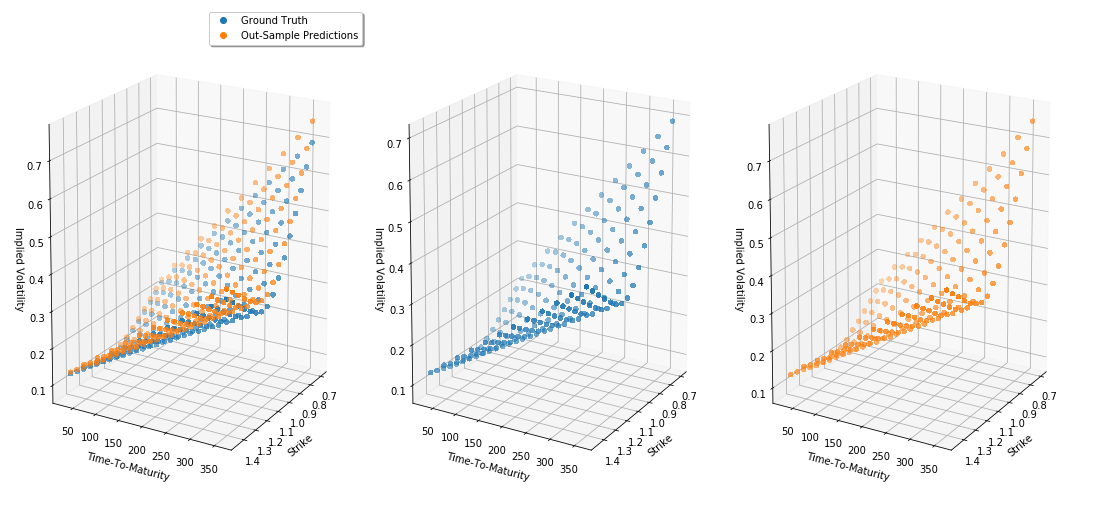

In [86]:
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)


plot_data = {
    "iv_grid_1": data_test[600-200:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": predicted_iv_grids[:,:,:,0],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "legend": ["Ground Truth", "Out-Sample Predictions"]
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 1, view_angle=(15, 30))

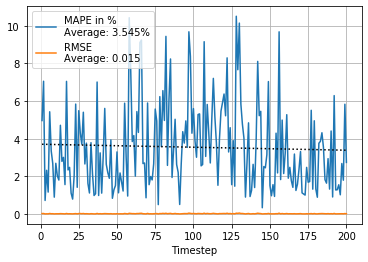

In [87]:
true_ivs = data_test[600-200:,:,:,0]
predicted_ivs = predicted_iv_grids[:,:,:,0]

mape = np.mean(np.abs(true_ivs-predicted_ivs)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_ivs,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)


mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")

plt.grid()

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")
#plt.title("Predicted IV Grids to Ground Truth Test Data IV Grids")
plt.savefig("MAPE_Predicted_1.pdf")

### Inference on test data with training 

In [72]:
# train the model
path = f"./models/deep_transformer/res{test_id}/"
best_model_new, _ = transformer_model.transformer_no_dynamic_arbitrage_retrain_with_new_data(
    new_data=feature_data_test,
    trained_model=best_model,
    epochs=1, 
    path_to_save_model=path, 
    path_to_save_loss=path, 
    device="cpu"
)
print(best_model_new)

Data shape with extra features:  (600, 8)
Epoch: 0 , Call Grids MSE Loss: 0.00926945934251412
Epoch: 1 , Call Grids MSE Loss: 0.01355105689281066
best_train_NDA_trained_twice_0.pth


In [67]:
path = f"./models/deep_transformer/res{test_id}/"
best_model_new = "best_train_NDA_trained_twice_0.pth"

In [68]:
prediction_features_new = transformer_model.inference_with_new_data(feature_data_test, path, best_model_new)
print(prediction_features_new.shape)

Data shape with extra features:  (600, 8)
(200, 4)


(200, 4)


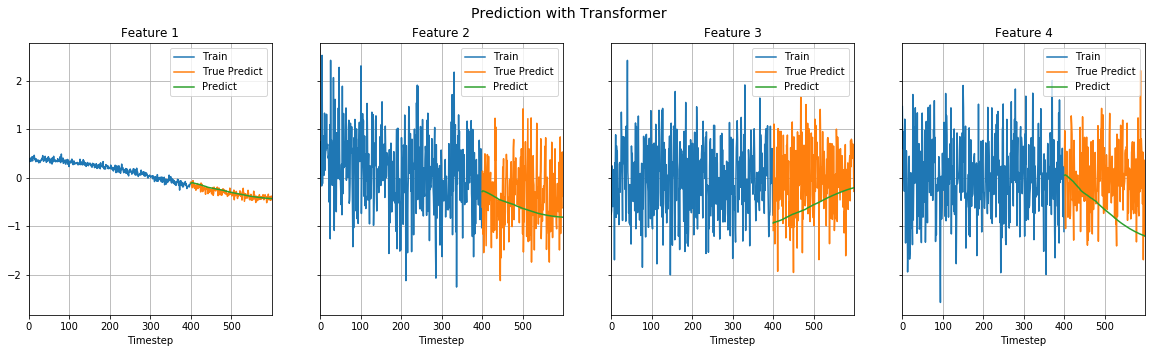

In [88]:
num_train_data_points = 600 - 200

true_ = feature_data_test[num_train_data_points:]

boot_strap_errors = in_sample_errors[np.random.randint(low=0, high=in_sample_errors.shape[0], size=true_.shape[0]),:]
print(boot_strap_errors.shape)
pred_vec_new = prediction_features_new#+boot_strap_errors

fig = plot_features_with_prediction(
    data=feature_data_test[:num_train_data_points],
    prediction=pred_vec_new,
    true_predictions=true_,
    use_true_predictions=True,
    save_path_and_name=f"prediction_with_transformer_test{test_id}.pdf",
    params={
        "fig_title":"Prediction with Transformer",
        "share_y": True
    }
)

In [89]:
predicted_iv_grids_new = feature_extractor.create_iv_grids_from_features(pred_vec_new)
print(predicted_iv_grids_new.shape)

(200, 12, 16, 1)


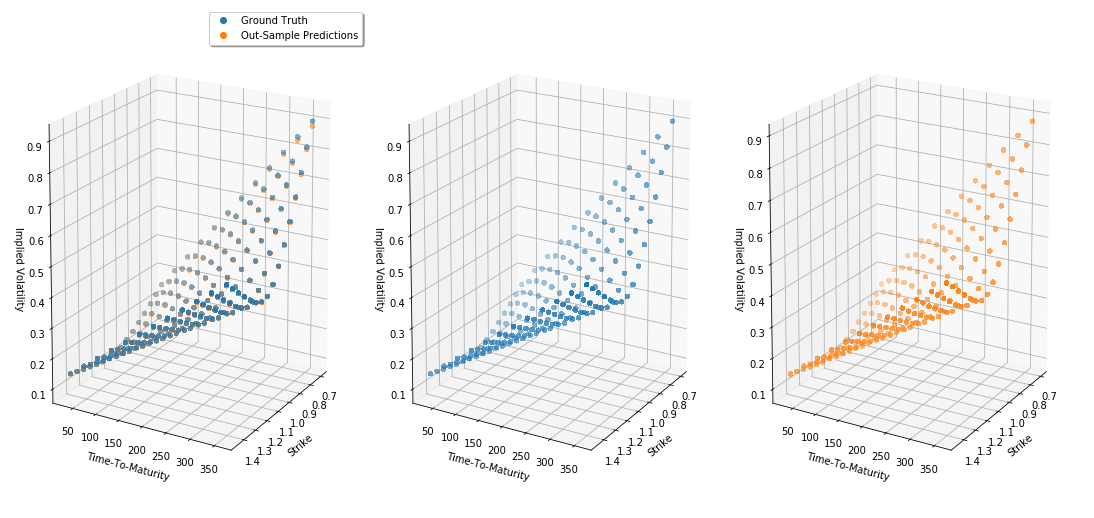

In [90]:
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)


plot_data = {
    "iv_grid_1": data_test[600-200:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": predicted_iv_grids_new[:,:,:,0],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "legend": ["Ground Truth", "Out-Sample Predictions"]
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 179, view_angle=(15, 30))

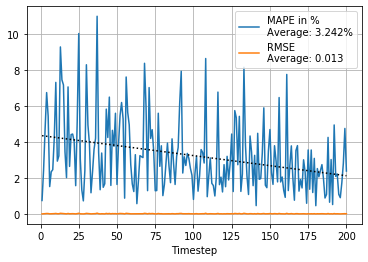

In [91]:
true_ivs = data_test[600-200:,:,:,0]
predicted_ivs_new = predicted_iv_grids_new[:,:,:,0]

mape = np.mean(np.abs(true_ivs-predicted_ivs_new)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_ivs_new,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)


mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")

plt.grid()

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")
#plt.title("Predicted IV Grids to Ground Truth Test Data IV Grids \n With Training on First 400 Data Points of Test Data")
plt.savefig("MAPE_Predicted_2.pdf")

## NSA IVS DNN

In [17]:
# create nsa_ivs_dnn
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)
beta = np.array([1e-1,1e-1,1e-1,1e-1])

# same as data above but needs different shape
data_nsa_train = np.genfromtxt(f"../data/test{test_id}_data_sabr_test.csv", delimiter=',').astype('float32')
nsa_ivs = NSA_IVS_DNN(data_nsa_train, [strikes, ttms], (2,30,30), beta)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                5850      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 6,811
Trainable params: 6,811
Non-trainable params: 0
_________________________________________________________________


In [18]:
# train NSA DNN using training data
history = nsa_ivs.train(epochs=50)

# save NSA DNN
nsa_ivs.save_model(f"nsa_dnn_model{test_id}")

Epoch 1/50
600/600 [==============================] - 7s 12ms/step - total_loss: 2.4804 - reconstruction_loss: 2.4403 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 0.0401
Epoch 2/50
600/600 [==============================] - 7s 11ms/step - total_loss: 1.0062 - reconstruction_loss: 0.9852 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 0.0210
Epoch 3/50
600/600 [==============================] - 7s 11ms/step - total_loss: 0.5836 - reconstruction_loss: 0.5645 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 0.0191
Epoch 4/50
600/600 [==============================] - 7s 11ms/step - total_loss: 0.5501 - reconstruction_loss: 0.5314 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 0.0187
Epoch 5/50
600/600 [==============================] - 7s 12ms/step - total_loss: 0.4918 - reconstruction_loss: 0.4733 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 0.0185
Epoch 6/50

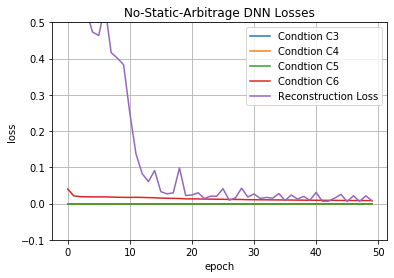

In [22]:
from matplotlib import pyplot as plt

plt.plot(history.history['nsa_C3'])
plt.plot(history.history['nsa_C4'])
plt.plot(history.history['nsa_C5'])
plt.plot(history.history['nsa_C6'])
plt.plot(history.history['reconstruction_loss'])
#plt.plot(history.history['total_loss'], ls=':', c='black')
plt.title('No-Static-Arbitrage DNN Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['Condtion C3','Condtion C4','Condtion C5','Condtion C6','Reconstruction Loss', 'Total Loss'], loc='upper right')
plt.legend(['Condtion C3','Condtion C4','Condtion C5','Condtion C6','Reconstruction Loss'], loc='upper right')

plt.grid()
#plt.yscale("log")
#plt.ylim(1e-9,1e9)
plt.ylim(-0.1,0.5)

#plt.show()
plt.savefig("nsa_dnn_losses.pdf")

In [23]:
# load NSA DNN
nsa_ivs.load_model(f"nsa_dnn_model{test_id}")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                5850      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 6,811
Trainable params: 6,811
Non-trainable params: 0
_________________________________________________________________


In [24]:
#  create surfaces

strikes_test = np.arange(0.65, 1.55, 0.04)
ttms_test = np.arange(15, 415, 15)

in_sample_nsa_ivs = nsa_ivs.predict_all_surfaces(data_nsa_train, strikes_test, ttms_test)

In [25]:
strikes = np.arange(0.7, 1.5, 0.05)
#ttms = np.arange(1, 13, 1)
ttms = np.arange(30, 390, 30)

legend = ["NSA DNN Test Predictions", "Ground Truth"]

plot_data = {
    "iv_grid_1": data_nsa_train,
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_surface_1": in_sample_nsa_ivs,
    "stikes_surface_1": strikes_test,
    "ttms_surface_1": ttms_test,
    "legend": legend
}

Plt_1 = IV_Plotting_Helper(data=plot_data)

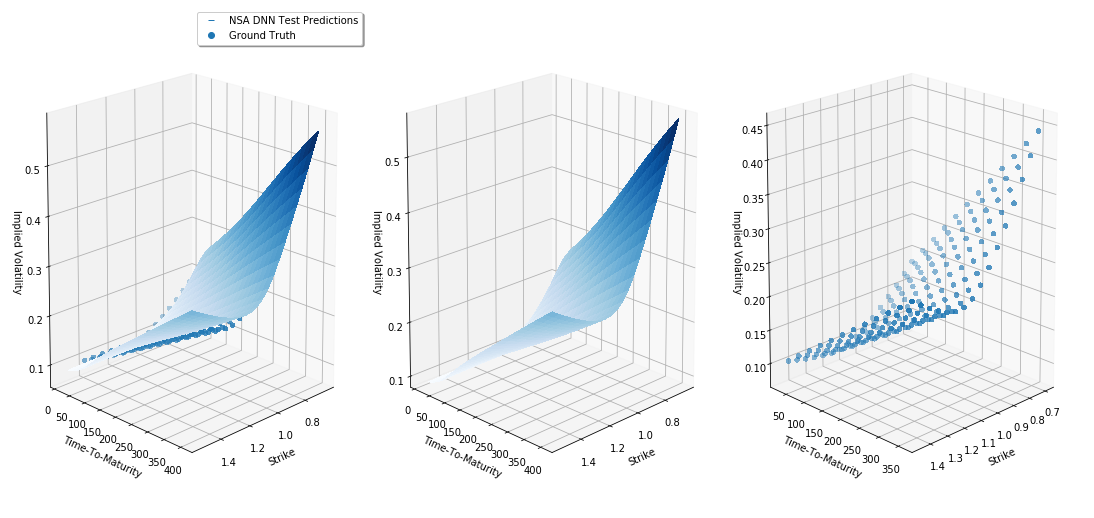

In [26]:
fig = Plt_1.plot_all_in_one(ind = 0, view_angle=(15, 45))

In [96]:
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

nsa_ivs_for_predictions = nsa_ivs.predict_all_surfaces(predicted_iv_grids_new[:,:,:,0], strikes_test, ttms_test)

legend = ["NSA IVS for Ground Truth", "NSA IVS for Prediction", "Ground Truth Grid", "Predicted Grid"]

plot_data = {
    "iv_grid_1": data_nsa_train[600-180:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_surface_1": in_sample_nsa_ivs[600-180:],
    "stikes_surface_1": strikes_test,
    "ttms_surface_1": ttms_test,
    "iv_grid_2": predicted_iv_grids_new[:,:,:,0],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "iv_surface_2": nsa_ivs_for_predictions,
    "stikes_surface_2": strikes_test,
    "ttms_surface_2": ttms_test,
    "legend": legend
}

Plt_2 = IV_Plotting_Helper(data=plot_data)

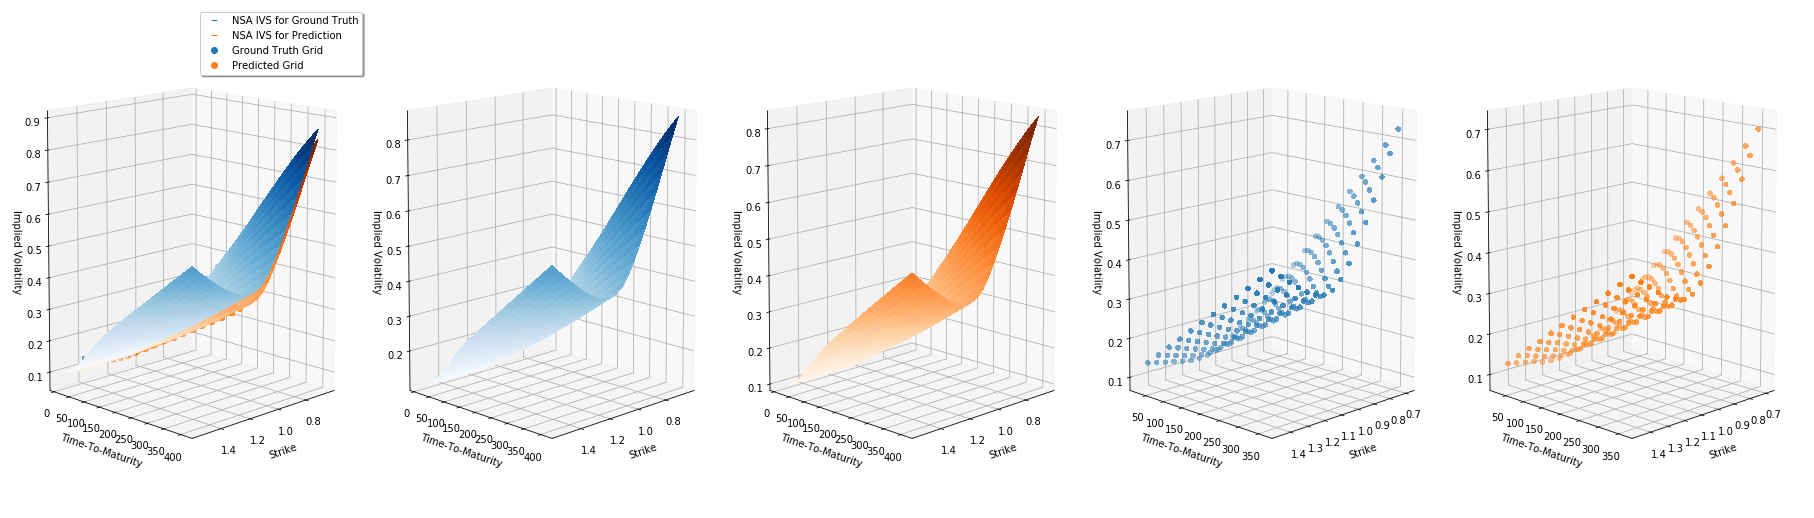

In [97]:
fig = Plt_2.plot_all_in_one(ind = 1, view_angle=(10, 45))
plt.savefig("nsda_iv_example.pdf")

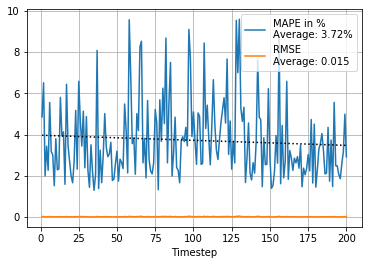

In [98]:
import matplotlib.pyplot as plt

true_ivs = data_test[600-200:,:,:,0]
predicted_iv_surfaces = nsa_ivs.predict_all_surfaces(predicted_iv_grids[:,:,:,0], strikes, ttms)

mape = np.mean(np.abs(true_ivs-predicted_iv_surfaces)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_iv_surfaces,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)

mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")
plt.grid()

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")
#plt.title("No-Static-Arbitrage Predictions using Predicted IV Grids \n To Ground Truth Test Data IV Grids")
plt.savefig("MAPE_NSA_Predicted.pdf")

In [95]:
#Test for NSA Conditions for predicted implied vol surfaceses
ind = 1

violations = nsa_ivs.nsa_dnn.test_for_conditions(predicted_iv_surfaces[ind,:,:].flatten(), strikes_test, ttms_test)
#violations = nsa_ivs.nsa_dnn.test_for_conditions(predicted_iv_surfaces[ind,:,:].flatten(), np.arange(0.6, 1.6, 0.3), np.arange(15, 415, 90))

print([i.numpy()[0] for i in violations])

[0.0, 0.0, 0.0, 0.011915114]
